### Preparing Data

Generating 100 datapoints from the distribution $N(\left( \begin{array}{c} 2 \\ 2 \end{array}\right),\left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right))$.  

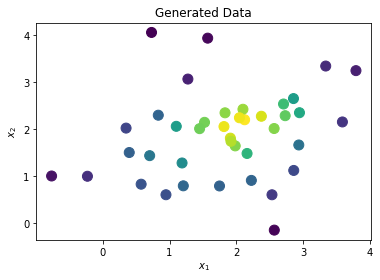

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Dataset = []
for _ in range(0,40):
    Dataset.append(list(np.random.default_rng().normal(2, 1, 2)))

x1 = [p[0] for p in Dataset]
x2 = [p[1] for p in Dataset]
x1x2 = np.vstack([x1,x2])
z = gaussian_kde(x1x2)(x1x2)
plt.scatter(x1, x2, c=z, s=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Generated Data")
plt.show()

### Generating the likelihood function

/opt/anaconda3/envs/PyTorchTest/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


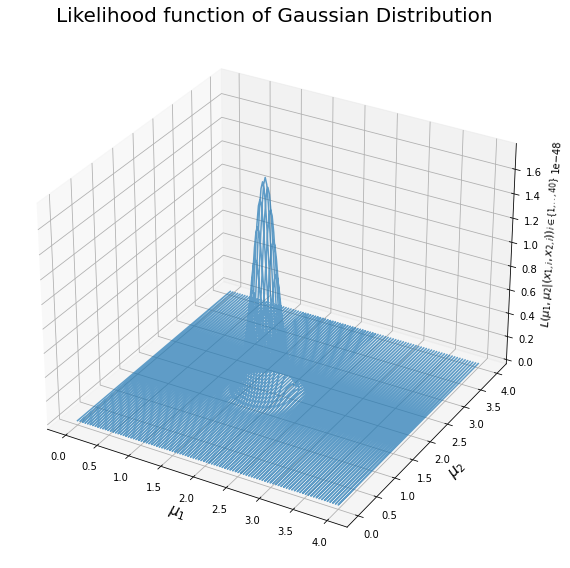

In [2]:
from StandardGaussianLikeli_Dian import Likelihood_Gaussian

Likeli = Likelihood_Gaussian(Dim=2, Dataset=Dataset)
Grid = np.linspace(0, 4, 100)
x = []
y = []
z = []
r = len(Grid)
for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]
fig = plt.figure(figsize=(8, 8), facecolor="white")
Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7)
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$L(\mu_1, \mu_2| {(x_{1,i}, x_{2,i})})_{i \in \{1,..,40\}}$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)
fig.tight_layout()
fig.show()

### Testing the Metropolis-Hasting MCMC algorithm with the likelihood function generated above

The total running time = (0 hours, 0 minutes, 4.02 seconds)


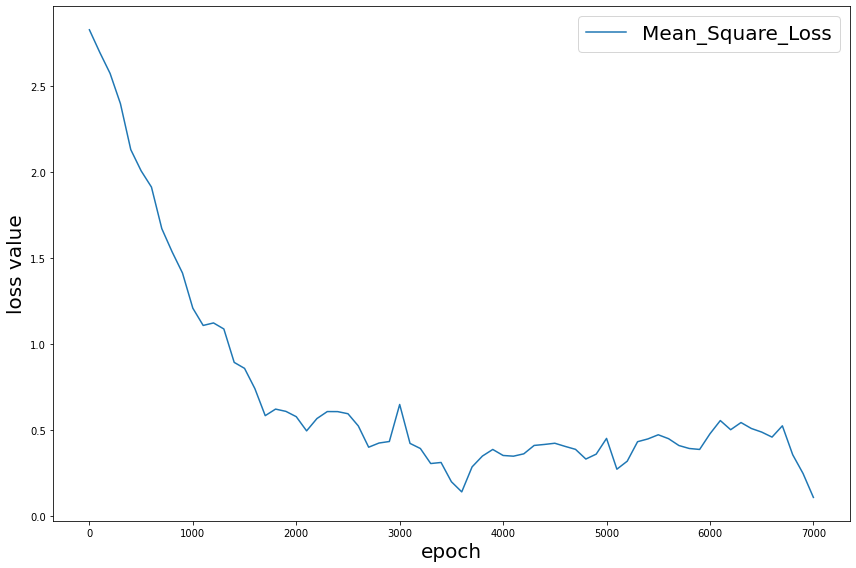

[1.9179145475343704, 1.9321554556081588]

In [3]:
from MHMC_Dian import MHMC
from ProposalDistributions_Dian import UniformProposalDistribution

q = UniformProposalDistribution(0.014, Dim=2)
MetropolisHasting = MHMC(rho=Likeli.L)
MetropolisHasting.PredictAndTest(
    qProb=q.qProb,
    qSamp=q.qSample,
    theta0=[0,0],
    testFreq=100,
    epoch=7000,
    thetaTrue=[2,2],
    runningTime=True
)

The total running time = (0 hours, 0 minutes, 4.19 seconds)


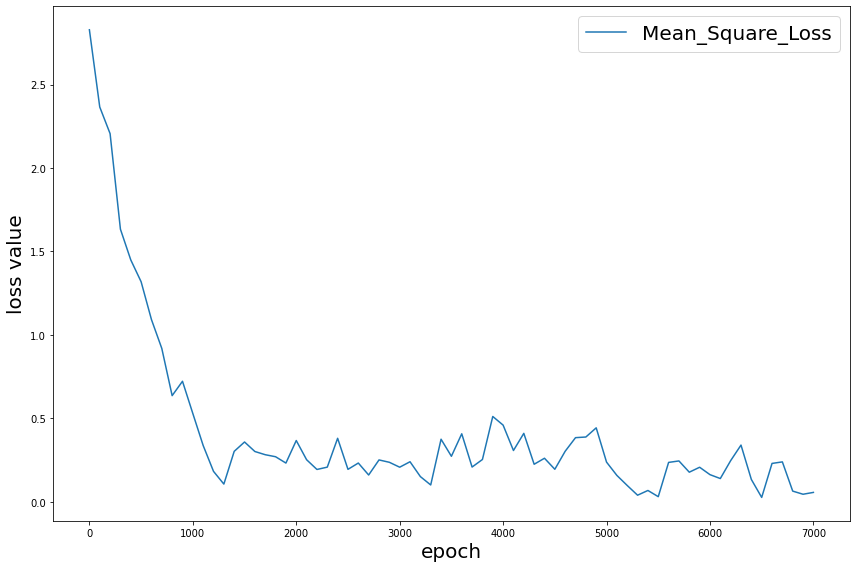

[2.0463906393029943, 1.9689421683823254]

In [4]:
from ProposalDistributions_Dian import GausianProposalDistributiob

q = GausianProposalDistributiob(sd=0.014, Dim=2)
MetropolisHasting = MHMC(rho=Likeli.L)
MetropolisHasting.PredictAndTest(
    qProb=q.qProb,
    qSamp=q.qSample,
    theta0=[0,0],
    testFreq=100,
    epoch=7000,
    thetaTrue=[2,2],
    runningTime=True
)